In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from pathlib import Path
from datetime import datetime
import urllib3
# from numba import jit

import yfinance as yahooFinance
import investpy

import kit as kit

In [2]:
# pd.set_option('display.max_rows', 500)
# pd.reset_option('display.max_rows')

pd.options.mode.chained_assignment = None  # default='warn'
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#### Function definition

In [3]:
class Asset:

    def __init__(self, ticker, name, source):
        self.ticker = ticker.upper()
        self.name = name
        self.source = source
        
    def get_asset_yahoo(self, ticker):
  
        ind = yahooFinance.Ticker(ticker).history(period="max")
        ind = ind["Close"]
        ind.name = ticker.split('.', 1)[0]

        return ind

    def get_asset_investing(self, ticker, name, date_beg='01/01/2009'):

        search = investpy.search_quotes(text=name, n_results=1)
        ind = search.retrieve_historical_data(from_date=date_beg, to_date=datetime.today().strftime('%d/%m/%Y'))["Close"]
        ind.name = ticker

        return ind

    def get_asset_local(self, ticker):

        ind = pd.read_csv(asset, sep=";", decimal=',').set_index('Date')
        ind.index = pd.to_datetime(ind.index, format="%d/%m/%Y")

        return ind

    def get_asset(self):
        
        if self.source.lower() == "yahoo":           
            prices = self.get_asset_yahoo(self.ticker)
        elif self.source.lower() == "investing":      
            prices = self.get_asset_investing(self.ticker, self.name)
        elif self.source.lower() == "csv":        
            prices = self.get_asset_local(self.ticker)
        else:
            raise ValueError(f"{self.source} is not a valid asset source")
        
        return pd.DataFrame(prices)

In [4]:
class Portfolio:
    
    def __init__(self, name, asset_list):
        self.name = name
        self.asset_list = asset_list

    ##### LOAD ####    
    def load(self):
        
        p = pd.concat([asset.get_asset() for asset in self.asset_list],axis=1)
        
        return p
    
    #### TRACK ####
    def frame_returns(self, p):
    
        r = p.pct_change()

        return r
    
    def create_trades(self):
    
        t = pd.DataFrame(columns=["Date", "Ticker", "Amount"])
        
        t = t.append({"Date": "07-01-2021","Ticker":"4GLD", "Amount":300.88}, ignore_index=True)
        t = t.append({"Date": "07-01-2021","Ticker":"XDEM", "Amount":3728.27}, ignore_index=True)
        t = t.append({"Date": "28-03-2021","Ticker":"4GLD", "Amount":-282.40}, ignore_index=True)
        t = t.append({"Date": "29-03-2021","Ticker":"4GLD", "Amount":273.24}, ignore_index=True)
        t = t.append({"Date": "14-07-2021","Ticker":"PRUD", "Amount":700.00}, ignore_index=True)
        t = t.append({"Date": "15-07-2021","Ticker":"FSMI", "Amount":2800.00}, ignore_index=True)
        t = t.append({"Date": "13-10-2021","Ticker":"WCOA", "Amount":2240.10}, ignore_index=True)
        t = t.append({"Date": "02-11-2021","Ticker":"ZPRS", "Amount":1494.57}, ignore_index=True)
        t = t.append({"Date": "02-11-2021","Ticker":"EUNZ", "Amount":1991.72}, ignore_index=True)
        t = t.append({"Date": "08-12-2021","Ticker":"BTC-EUR", "Amount":584.46}, ignore_index=True)
        t = t.append({"Date": "28-01-2022","Ticker":"4GLD", "Amount":518.20}, ignore_index=True)
        t = t.append({"Date": "28-01-2022","Ticker":"BRYN", "Amount":2487.15}, ignore_index=True)
        t = t.append({"Date": "11-02-2022","Ticker":"EUA", "Amount":624.00}, ignore_index=True)     

        return t

    def join_trades(self, r, t):
    
        t["Date"] = pd.to_datetime(t["Date"], format="%d-%m-%Y")
        t = t.set_index(["Ticker","Date"]).rename(columns={'Amount':'Trades'})
        r_stack = r.stack().reset_index().rename(columns={'level_1':'Ticker', 0: 'Returns'}).set_index(["Ticker", "Date"])
        rt = r_stack.join(t).unstack(level=0)
        rt.loc[:,"Trades"].fillna(0, inplace = True)

        return rt
    
    # @jit(nopython=True)
    def roll(self, a, b):
        res = np.empty(b.shape)
        res[0] = b[0]
        for i in range(1, res.shape[0]):
            res[i] = res[i-1] * (1 + a[i]) + b[i]
        return res

    def compute_wealth(self, rt):

        rtw = rt.copy()

        for i in rtw["Trades"].columns:
            rtw[("Total", i)] = self.roll(*np.nan_to_num(rtw[[("Returns", i), ("Trades", i)]].values.T))

        return rtw
    
    def portfolio_rets_weights(self, rtw):
    
        w = rtw["Total"].div(rtw["Total"].sum(axis=1), axis=0)   
        r = rtw["Returns"]   
        r['PORT'] =  (w * r).sum(axis=1) 

        return r, w
    
    def rolling_vol(self, r, time_period = 90, col_drop_plot = None):
    
        roll_vol = r.drop(columns = col_drop_plot).rolling(time_period, min_periods = int(time_period*0.2)).apply(kit.annualize_vol)   
        roll_vol.plot(figsize=(16,5), title = '{}-periods rolling volatility'.format(time_period))
    
        return roll_vol

    def portfolio_report(self, df, weights = None, date_beg = None, date_end = None, col_drop_plot = None, time_period = 90):

        if date_end == None:
            date_end = df.index[-1]

        if col_drop_plot == None:
            (1+df.dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
            df.dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown
        else:
            (1+df.drop(columns = col_drop_plot).dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
            df.drop(columns = col_drop_plot).dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown

        stats = kit.summary_stats(df.dropna()[date_beg:date_end], riskfree_rate=0)
    #     roll_vol = rolling_vol(df.dropna()[date_beg:date_end], time_period = time_period, col_drop_plot = col_drop_plot)
    
        if weights is not None:
            weights.dropna().plot(figsize=(16,5), title = 'Portfolio weights')

        return stats
    
    def track(self):
        
        p = self.load()
        r = self.frame_returns(p)
        t = self.create_trades()
        rt = self.join_trades(r, t)
        self.rtw = self.compute_wealth(rt)
        self.r, self.w = self.portfolio_rets_weights(self.rtw)
        self.stats = self.portfolio_report(self.r, weights = self.w, date_beg = "2021-01-06", col_drop_plot = ["BTC-EUR", "EUA"])
        roll_vol = self.rolling_vol(r.dropna()["2021-01-06":], time_period = 90, col_drop_plot = ["BTC-EUR", "EUA"])
        
        return self.stats
    
    def backtest(self, freq = None, time_period = 90):
        '''
        freq: "W", "M", "B", default None
        '''
        
        w = self.w.copy()
        w.iloc[:-1,:]=np.nan
        w = w.fillna(method="bfill")

        r = self.rtw["Returns"] 
        if freq is not None:         
            r = r.resample(freq).apply(kit.compound)
        r['PORT'] = (w * r).sum(axis=1) 

        col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN", "EUA"]

        self.stats_long = self.portfolio_report(r, date_beg = "2017-12", weights = w, col_drop_plot = col_drop_plot, time_period = time_period)
        roll_vol = self.rolling_vol(r.dropna()["2017-12":], col_drop_plot = col_drop_plot, time_period = time_period)
        
        return self.stats_long
    

#### Parameters initialization

In [5]:
# Local: Write your own path. csv must contain only two columns, 'Date' with date format "%d/%m/%Y" and 'asset name' (e.g FSMI) with asset prices
list_local = glob.glob(r'C:\Users\aguil\OneDrive\Escritorio\Escritorio\Python Projects\6. Investing projects\data\Assets' + "/*.csv")

In [6]:
asset1 = Asset(ticker="EUNL.DE", name="MSCI World", source="Yahoo")
asset2 = Asset(ticker="XDEM.F", name="MSCI World Momentum", source="Yahoo")
asset3 = Asset(ticker="4GLD.DE", name="Xetra-Gold", source="Yahoo")
asset4 = Asset(ticker="WCOA.MI", name="Wisdomtree Enhac Comm", source="Yahoo")
asset5 = Asset(ticker="ZPRS.DE", name="MSCI World Small Cap", source="Yahoo")
asset6 = Asset(ticker="EUNZ.F", name="MSCI EM Min Vol", source="Yahoo")
asset7 = Asset(ticker="BTC-EUR", name="Bitcoin", source="Yahoo")
asset8 = Asset(ticker="BRYN.DE", name="Berkshire Hathaway", source="Yahoo")
asset9 = Asset(ticker="FSMI", name="Fundsmith Equity T Acc EUR", source="Investing")
asset10 = Asset(ticker="PRUD", name="MFS Meridian Prudent Wealth I1 EUR", source="Investing")
asset11 = Asset(ticker="EUA", name="Carbon Emissions", source="Investing")
asset_list = [asset1, asset2, asset3, asset4, asset5, asset6, asset7, asset8, asset9, asset10, asset11]

#### Execution

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.050069,0.129287,-0.428315,4.526927,0.013913,0.020203,0.387270,-0.091344
BRYN,0.450786,0.175405,0.107855,4.198998,0.015975,0.022061,2.569967,-0.075175
BTC-EUR,0.354362,0.784723,0.199685,4.880334,0.061803,0.089074,0.451576,-0.523755
EUA,0.921914,0.453919,-1.155726,8.013067,0.049012,0.071615,2.031010,-0.276781
EUNL,0.197722,0.143780,-0.400782,5.731483,0.014503,0.020811,1.375173,-0.108538
EUNZ,0.106044,0.117944,-0.359056,4.148006,0.012321,0.016457,0.899104,-0.054096
FSMI,0.117493,0.123254,-0.207008,4.126646,0.012595,0.016659,0.953256,-0.153347
PRUD,0.085059,0.065718,-0.467851,4.641088,0.006958,0.010127,1.294311,-0.051620
WCOA,0.505572,0.158719,0.008910,13.661415,0.012503,0.023200,3.185327,-0.080140


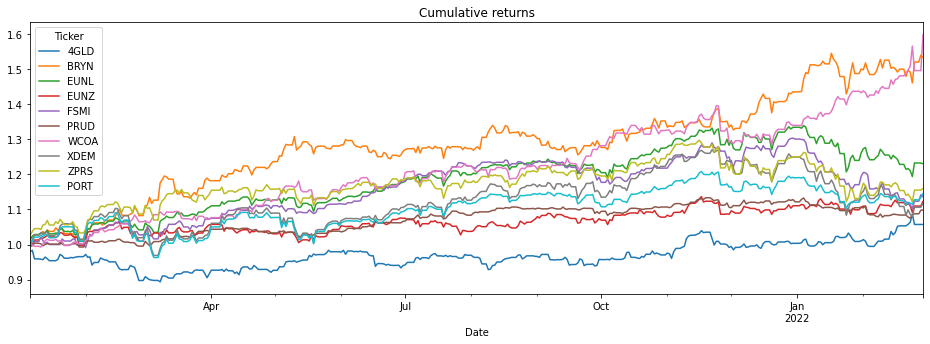

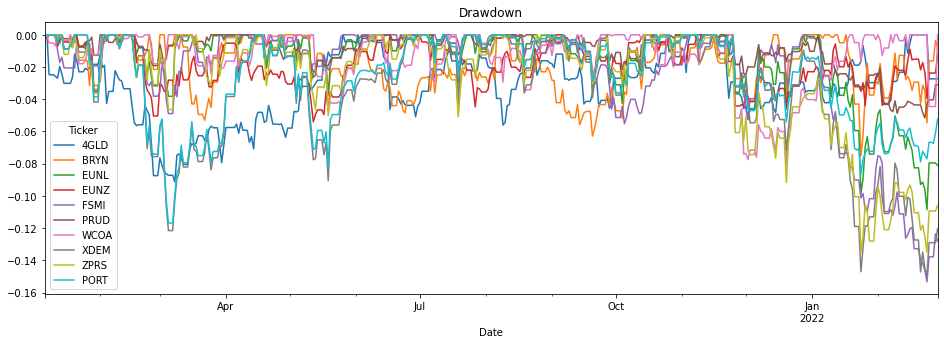

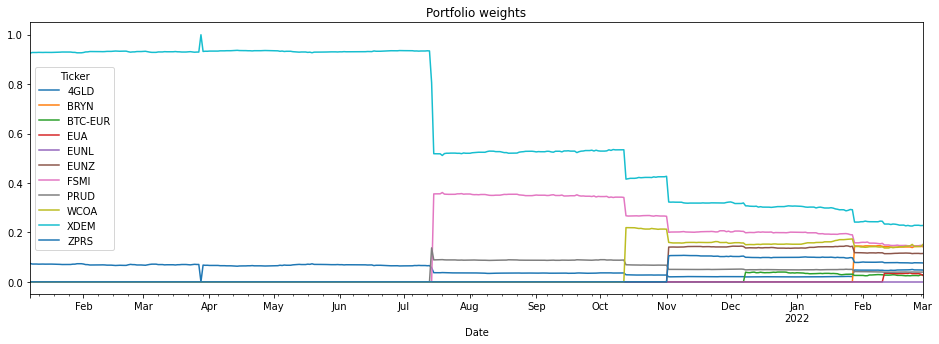

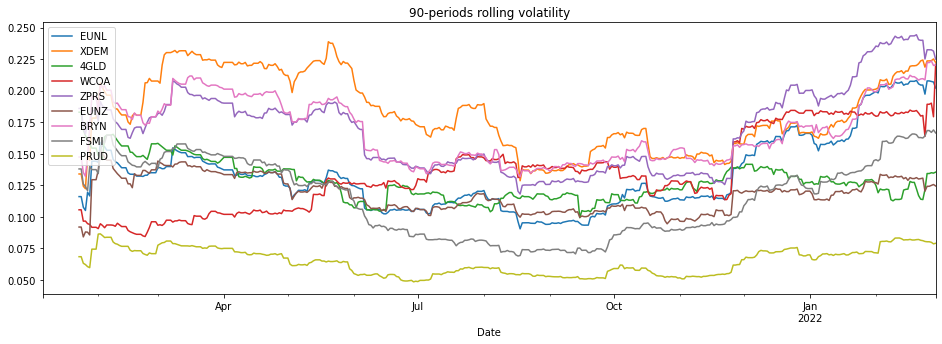

In [7]:
portfolio = Portfolio(name="Jaime's Portfolio", asset_list=asset_list)
stats = portfolio.track()
stats

# Other analysis

#### Test current weights on a longer period

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.110744,0.127822,-0.056913,9.283441,0.012060,0.018943,0.866397,-0.182267
BRYN,0.143977,0.213931,-0.114943,8.833082,0.020397,0.032136,0.673009,-0.287161
BTC-EUR,0.390706,0.781255,-0.092481,10.489144,0.060344,0.092753,0.500101,-0.827479
EUA,0.767714,0.452756,-0.414742,6.291815,0.045263,0.063202,1.695647,-0.489272
EUNL,0.122921,0.175401,-0.981256,14.548278,0.017979,0.028227,0.700801,-0.336322
EUNZ,0.053206,0.152233,-0.965372,9.697331,0.016840,0.024036,0.349506,-0.267947
FSMI,0.127248,0.153372,-0.761903,8.548368,0.016488,0.024412,0.829670,-0.269354
PRUD,0.088786,0.073288,-0.102858,4.903405,0.007352,0.010353,1.211471,-0.073030
WCOA,0.100442,0.115948,-0.629630,8.268232,0.012611,0.017827,0.866266,-0.218176


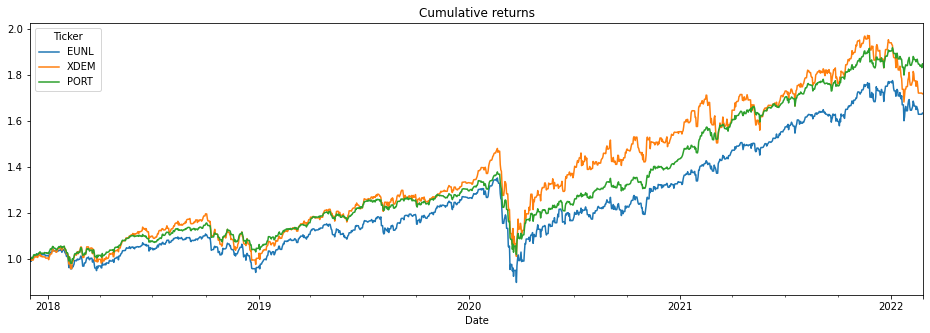

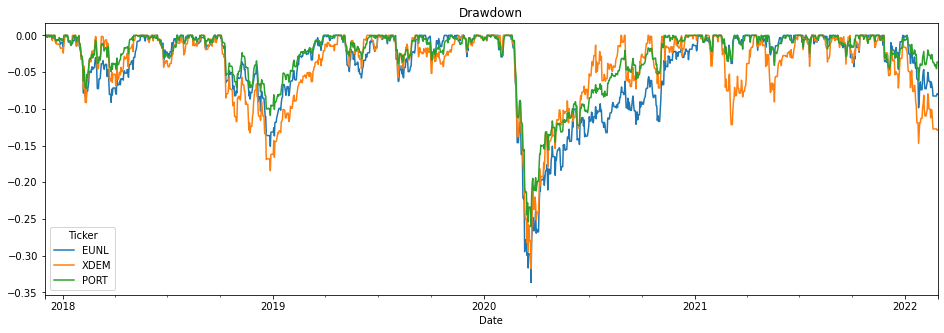

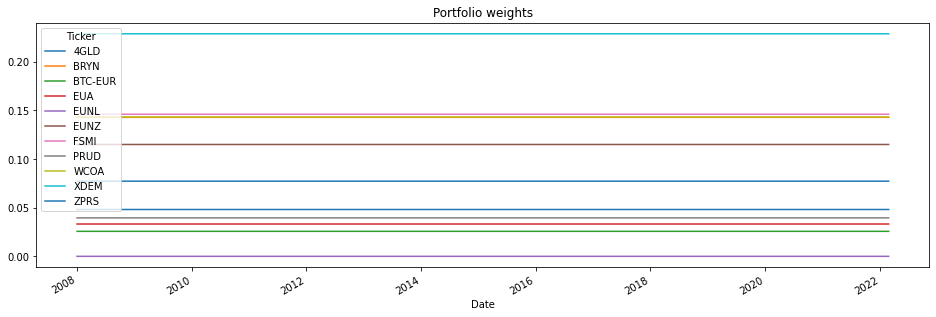

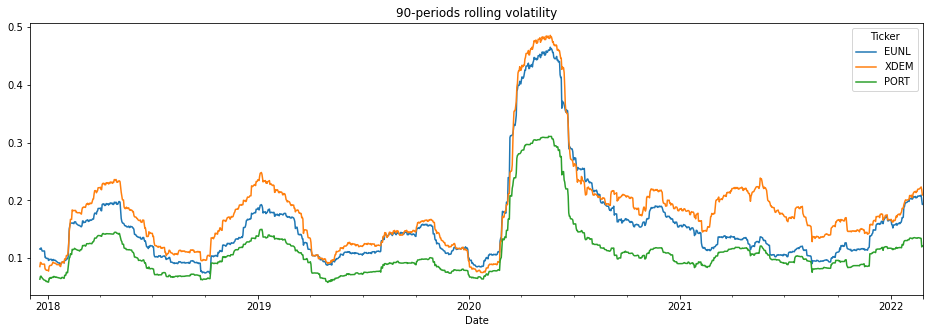

In [38]:
stats_long = portfolio.backtest()
stats_long

In [36]:
portfolio.w.iloc[-1].sort_values()

Ticker
EUNL       0.000000
BTC-EUR    0.025691
EUA        0.033228
PRUD       0.039506
4GLD       0.048141
ZPRS       0.077263
EUNZ       0.115001
BRYN       0.142924
WCOA       0.143319
FSMI       0.146109
XDEM       0.228817
Name: 2022-02-26 00:00:00, dtype: float64

#### Monthly/weekly/business days report

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.109298,0.116295,-0.796771,5.767658,0.026795,0.039017,0.939828,-0.173035
BRYN,0.154945,0.205945,-0.617214,5.890139,0.047041,0.072263,0.752363,-0.254979
BTC-EUR,0.422059,0.792625,-0.080401,3.760497,0.167699,0.228991,0.532482,-0.823520
EUA,0.755205,0.446024,-0.073339,4.036789,0.088421,0.105153,1.693192,-0.453457
EUNL,0.125421,0.169771,-1.657279,13.438810,0.040833,0.057499,0.738768,-0.292886
EUNZ,0.048413,0.139457,-1.105765,7.776535,0.034270,0.048332,0.347150,-0.243539
FSMI,0.127766,0.150464,-1.700642,10.657238,0.037285,0.053853,0.849152,-0.221121
PRUD,0.088622,0.066582,-0.849052,5.792291,0.015003,0.020330,1.331035,-0.056389
WCOA,0.097989,0.107295,-0.639949,5.209230,0.024344,0.031443,0.913260,-0.189856


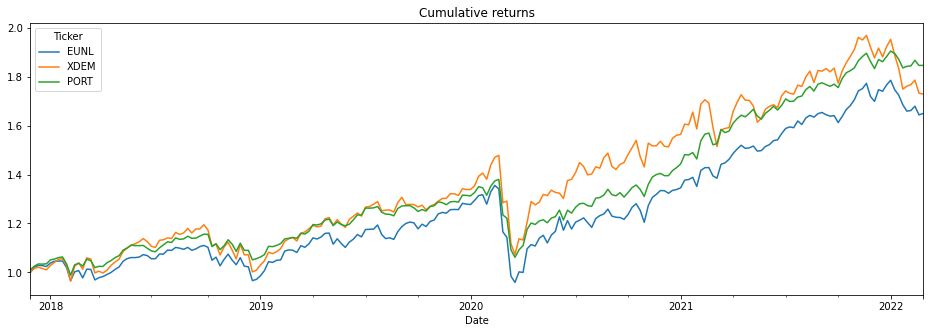

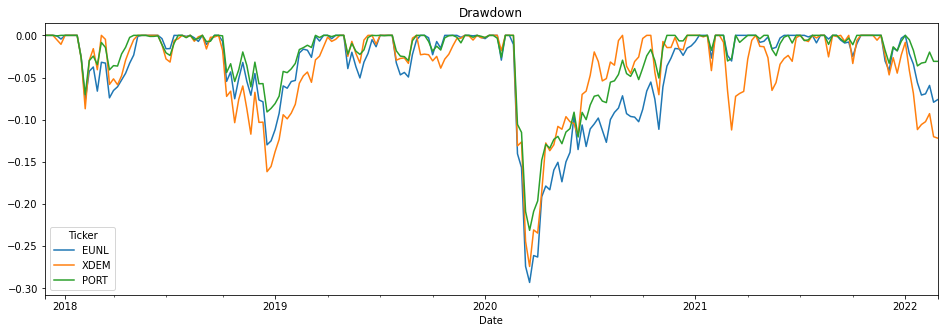

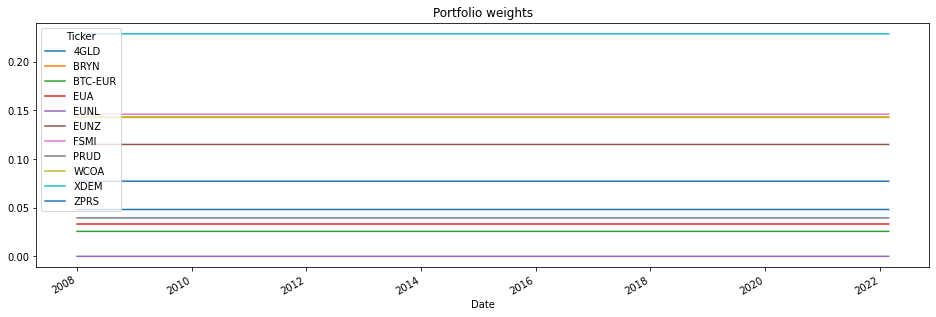

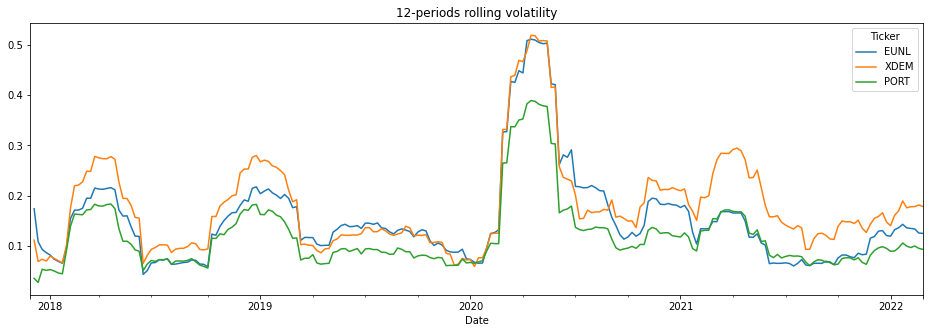

In [45]:
stats_long_w = portfolio.backtest(freq = 'W', time_period = 12)
stats_long_w

#### Plot density function of returns

(-0.04, 0.04)

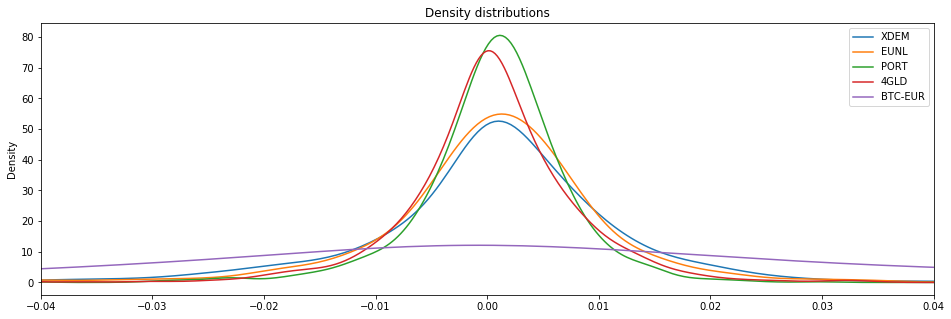

In [60]:
r = df_portfolio_b.loc["2017-12":, ["XDEM", "EUNL", "PORT", "4GLD", "BTC-EUR"]]
x_lim = 0.04

# r.hist(bins=30, figsize=(15,10), label='x')

r.plot.kde(figsize=(16,5), title = 'Density distributions')
plt.xlim([-x_lim, +x_lim])

#### Get rolling correlation of rest of assets against a particular asset

,4GLD,BTC-EUR,WCOA,PRUD,EUNZ,FSMI,XDEM,PORT,ZPRS,EUNL
0,-0.018522,0.175583,0.450048,0.684403,0.686326,0.715056,0.76495,0.882312,0.903893,1.0


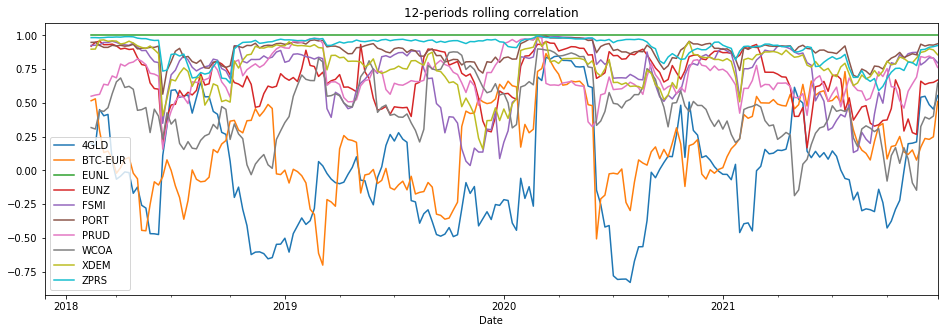

In [61]:
def rolling_corr(r, time_period = 90, col= 'XDEM'):
    
    corr = r.rolling(time_period).corr()[col].unstack(level = 1)
    
    corr.plot(figsize=(16,5), title = '{}-periods rolling correlation'.format(time_period))
    
    return pd.DataFrame(corr.mean().sort_values(ascending = True)).T

r = df_portfolio_w.loc["2017-12":]

# Note: Daily data and data quality issues in funds could give unaccurate results (better with long monthly periods)
rolling_corr(r, time_period = 12, col = 'EUNL')

#### Study inclusion of alternative asset in the portfolio

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0.0,0.138123,0.123747,-1.150235,16.802194,0.010421,0.017306,1.116177,-0.257945
0.1,0.133817,0.127079,-1.132132,17.448385,0.010605,0.017820,1.053023,-0.266450
0.2,0.129434,0.130965,-1.100583,17.946555,0.010829,0.018390,0.988306,-0.274881
0.3,0.124973,0.135357,-1.058777,18.293469,0.011091,0.019011,0.923285,-0.283239
0.4,0.120436,0.140206,-1.009828,18.498091,0.011392,0.019682,0.858991,-0.291523
0.5,0.115824,0.145468,-0.956503,18.577211,0.011729,0.020419,0.796216,-0.299735
0.6,0.111138,0.151099,-0.901094,18.551416,0.012100,0.021163,0.735532,-0.307874
0.7,0.106380,0.157060,-0.845384,18.441996,0.012502,0.021936,0.677321,-0.315941
0.8,0.101550,0.163314,-0.790685,18.268921,0.012933,0.022733,0.621807,-0.323936
0.9,0.096649,0.169829,-0.737906,18.049738,0.013390,0.023568,0.569096,-0.331860


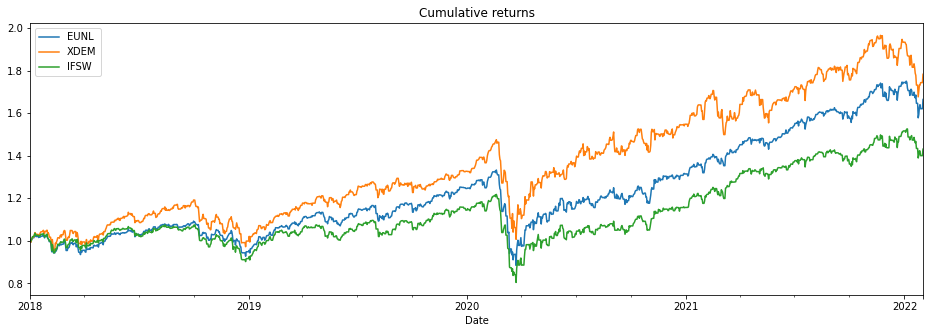

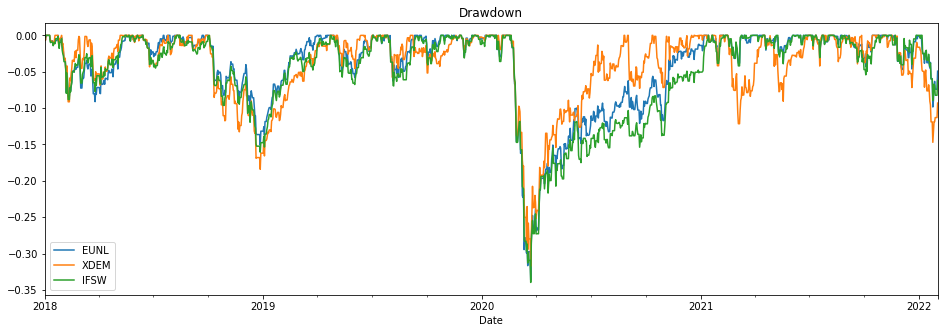

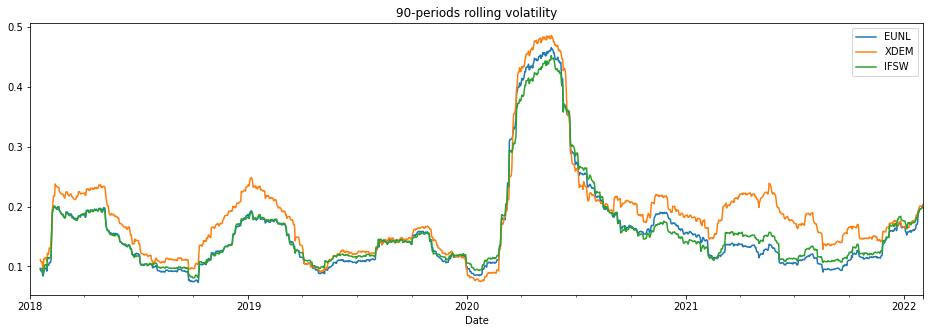

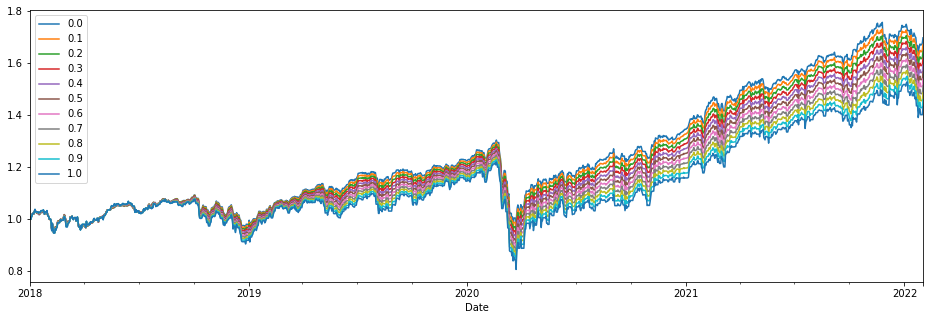

In [20]:
alt_name = 'IFSW'

# Get asset returns
alt_ticker = ['IFSW.MI']
alt_price = get_asset(list_yahoo = alt_ticker) 
alt_rets = alt_price.pct_change()["2016-09-28":]

# Append returns
r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
r.loc[:,alt_name] = r.loc[:,alt_name].fillna(0)
r = r.dropna()

# Optional: Include in portfolio report
col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN"]
portfolio_report(r, date_beg = "2018", col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(r["2018":], col_drop_plot = col_drop_plot)

# Optional: Get correlation matrix
# r['2018':].resample('M').apply(kit.compound).corr()

# Define a function that include given weight into portolio weights
def normalize(weight_series,  w):

    a = weight_series
    a = a*(1-w)
    a[alt_name] = w
    
    return a

# Define weights to backtest
weight_series = weights_portfolio.iloc[-1]
weights = np.array([normalize(weight_series,  w) for w in np.linspace(0,1,11)])

# Get results
results = (r @ weights.T)
results.columns = np.around(weights[:,-1],2).tolist()
(1+results["2018":]).cumprod().plot(figsize=(16,5))
kit.summary_stats(results["2018":], riskfree_rate = 0)

In [9]:
alt_name = 'IFSW'

# Get asset returns
alt_ticker = ['IFSW.MI']
alt_price = get_asset(list_yahoo = alt_ticker) 
alt_rets = alt_price.pct_change()["2016-09-28":]

#### EUA Analysis

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0.00,0.137413,0.161662,-0.689570,12.043858,0.016293,0.025235,0.850003,-0.336322
0.01,0.140878,0.161008,-0.693679,12.384250,0.015942,0.024874,0.874972,-0.336700
0.02,0.144313,0.160565,-0.689952,12.346519,0.015883,0.024786,0.898781,-0.337079
0.03,0.147718,0.160339,-0.682891,12.260382,0.015848,0.024724,0.921285,-0.337462
0.04,0.151092,0.160331,-0.672210,12.130856,0.015834,0.024679,0.942377,-0.337847
0.05,0.154437,0.160542,-0.657699,11.965145,0.015840,0.024653,0.961969,-0.338235
0.06,0.157750,0.160971,-0.639232,11.772278,0.015864,0.024659,0.979992,-0.338625
0.07,0.161033,0.161616,-0.616773,11.562628,0.015902,0.024682,0.996393,-0.339018
0.08,0.164284,0.162474,-0.590374,11.347360,0.015952,0.024758,1.011141,-0.339414
0.09,0.167504,0.163543,-0.560175,11.137835,0.016012,0.024866,1.024223,-0.339812


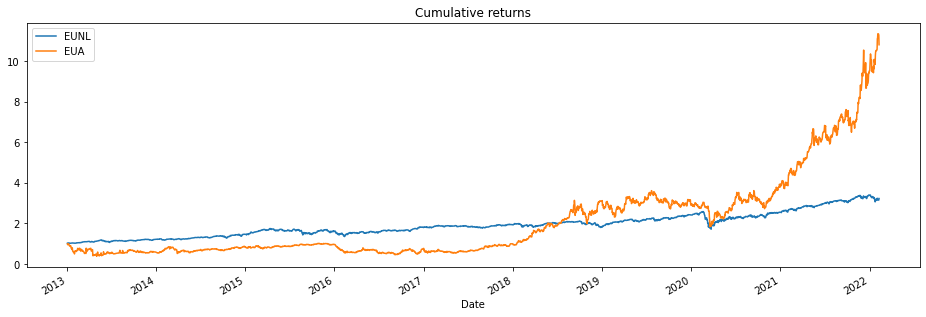

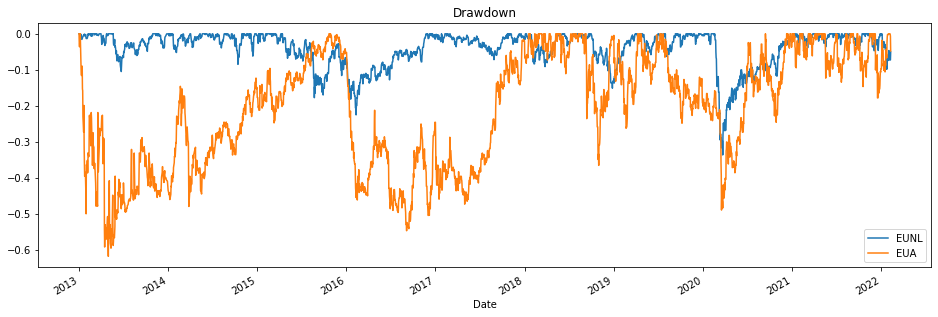

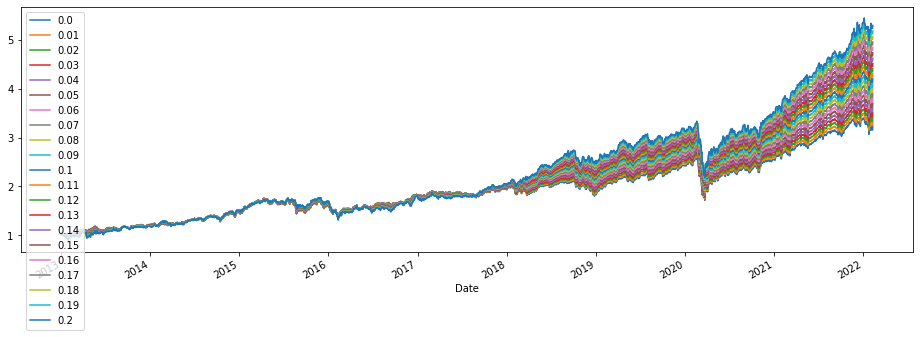

In [75]:
alt_ticker = [['Carbon Emissions', 'EUA']]
alt_price = get_asset(list_investing = alt_ticker)

alt_rets = alt_price.pct_change()["2013-01-01":]
# ["2016-09-28":]
alt_name = 'EUA'

# Append returns
r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
r[alt_name] = r[alt_name].fillna(0)
r = r[["EUNL", "EUA"]]
# r = r.dropna()

# Optional: Include in portfolio report
# col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN"]
stats = portfolio_report(r, date_beg = "2013", col_drop_plot = None)
# roll_vol = rolling_vol(r["2013":], time_period = 90, col_drop_plot = None)

# Optional: Get correlation matrix
# r['2013':].resample('M').apply(kit.compound).corr()

# Define a function that include given weight into portolio weights
def normalize(weight_series,  w):

    a = weight_series
    a = a*(1-w)
    a[alt_name] = w
    
    return a

# Define weights to backtest
# weight_series = weights_portfolio.iloc[-1]
weight_series = weights_portfolio[["EUNL"]].iloc[-1]
weight_series["EUNL"] = 1
# weight_series = 1
weights = np.array([normalize(weight_series,  w) for w in np.linspace(0,0.2,21)])

# Get results
results = (r @ weights.T)
results.columns = np.around(weights[:,-1],2).tolist()
(1+results["2013":]).cumprod().plot(figsize=(16,5))
kit.summary_stats(results["2013":], riskfree_rate = 0)

,EUA,EUNL
0,0.161823,1.0


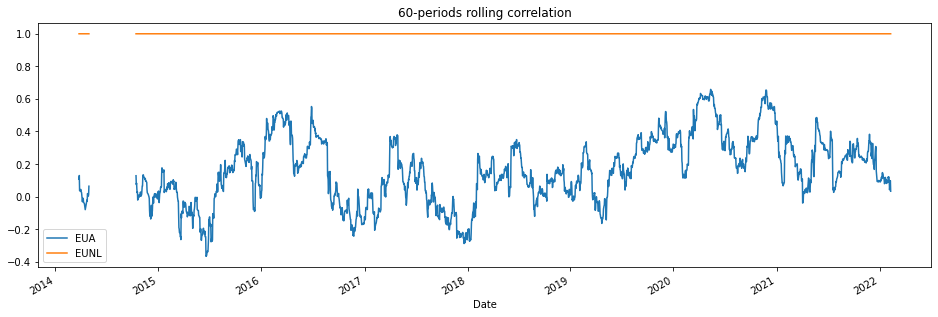

In [77]:
def rolling_corr(r, time_period = 90, col= 'XDEM'):
    
    corr = r.rolling(time_period).corr()[col].unstack(level = 1)
    
    corr.plot(figsize=(16,5), title = '{}-periods rolling correlation'.format(time_period))
    
    return pd.DataFrame(corr.mean().sort_values(ascending = True)).T

# r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
# r[alt_name] = r[alt_name].fillna(0)
# r = r[["WCOA", "EUA"]]["2018":]

r_w = r.resample('W').apply(kit.compound)
r_m = r.resample('M').apply(kit.compound)

# Note: Daily data and data quality issues in funds could give unaccurate results (better with long monthly periods)
rolling_corr(r["2013":], time_period = 60, col = 'EUNL')
# rolling_corr(r_w["2014":], time_period = 12, col = 'WCOA')
# rolling_corr(r_m["2014":], time_period = 6, col = 'EUNL')

<AxesSubplot:xlabel='Date'>

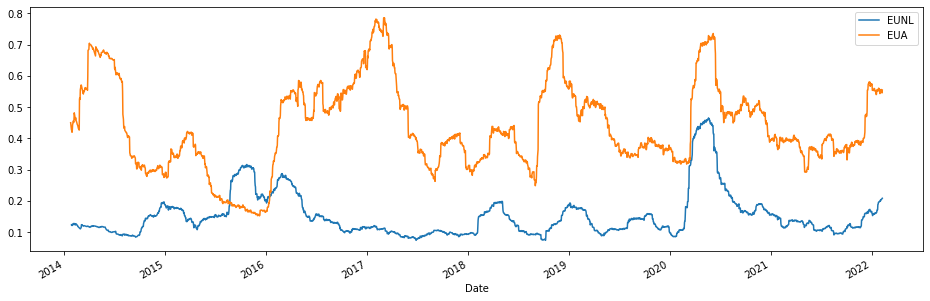

In [86]:
time_period = 90
roll_vol = r["2014":].rolling(time_period, min_periods = int(time_period*0.2)).apply(kit.annualize_vol)
roll_vol.plot(figsize=(16,5))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EUNL,0.146748,0.211348,-1.019292,13.257080,0.022018,0.034710,0.694343,-0.336322
EUA,0.860172,0.465638,-0.397023,6.453978,0.045980,0.065531,1.847297,-0.393436


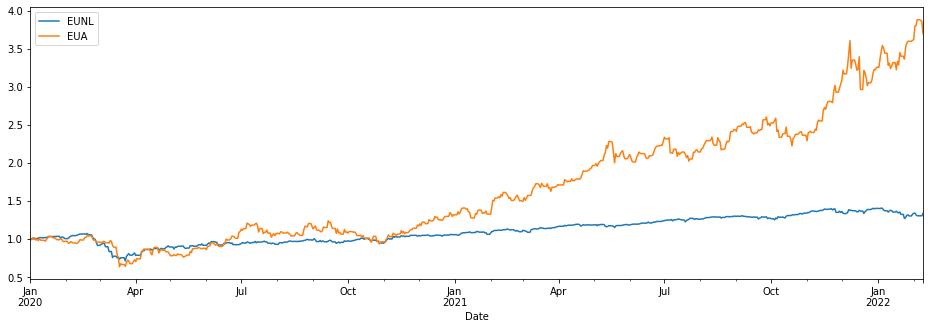

In [100]:
r_t = r["2020":]
(1+r_t).cumprod().plot(figsize=(16,5))
kit.summary_stats(r_t, riskfree_rate = 0)

In [27]:
portfolio.r

Ticker,4GLD,BRYN,BTC-EUR,EUA,EUNL,EUNZ,FSMI,PRUD,WCOA,XDEM,ZPRS,PORT
Date,,,,,,,,,,,,
2008-01-02,NaN,-0.010756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2008-01-03,NaN,0.005438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2008-01-04,NaN,-0.017817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2008-01-07,NaN,-0.017532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2008-01-08,NaN,0.013805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,0.0,0.011870,0.030874,0.002797,0.000000,0.000000,-0.002559,-0.005119,0.000000,0.000000,0.000000,0.001969
2022-02-23,0.0,-0.003609,-0.023872,0.056894,0.000000,0.000000,-0.004939,-0.003318,0.000000,0.000000,0.000000,0.000109
2022-02-24,0.0,-0.020648,0.038333,-0.079481,0.000000,0.000000,-0.008569,0.009165,0.000000,0.000000,0.000000,-0.005408
